# Import and Install

In [1]:
pip install git+https://github.com/csebuetnlp/normalizer -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install datasets -q

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from normalizer import normalize
from datasets import load_dataset
import torch
import numpy as np
import pandas as pd

# Loading Dataframe

In [4]:
df = pd.read_csv("/kaggle/input/imdb-bangla-gt-10k/imdb-bangla-gt-10000.csv")
df = df.iloc[:1000]

In [5]:
df

,Unnamed: 0,review,translated,sentiment
0,0,One of the other reviewers has mentioned that ...,অন্য একজন পর্যালোচক উল্লেখ করেছেন যে মাত্র 1 O...,positive
1,1,A wonderful little production. <br /><br />The...,একটি বিস্ময়কর সামান্য উত্পাদন. <br /><br />চি...,positive
2,2,I thought this was a wonderful way to spend ti...,আমি ভেবেছিলাম খুব গরম গ্রীষ্মের সপ্তাহান্তে সম...,positive
3,3,Basically there's a family where a little boy ...,মূলত একটি পরিবার আছে যেখানে একটি ছোট ছেলে (জেক...,negative
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","Petter Mattei এর ""লাভ ইন দ্য টাইম অফ মানি"" একট...",positive
...,...,...,...,...
995,995,Nothing is sacred. Just ask Ernie Fosselius. T...,কিছুই পবিত্র নয়। শুধু এর্নি ফসেলিয়াসকে জিজ্ঞ...,positive
996,996,I hated it. I hate self-aware pretentious inan...,আমি এটা ঘৃণা. আমি স্ব-সচেতন ভৌতিক উন্মাদনাকে ঘ...,negative
997,997,I usually try to be professional and construct...,যখন আমি চলচ্চিত্রের সমালোচনা করি তখন আমি সাধার...,negative
998,998,If you like me is going to see this in a film ...,যদি আপনি পছন্দ করেন যে আমি এটি আপনার স্কুলে এক...,negative


In [6]:
from datasets import Dataset, DatasetDict
train_df, valid_df = train_test_split(df, test_size = 0.3)
val_df, test_df = train_test_split(valid_df, test_size = 0.5)

In [7]:
train_df

,Unnamed: 0,review,translated,sentiment
354,354,"Like the previous poster, I am from northern V...","আগের পোস্টারের মতো, আমি উত্তর ভার্মন্ট থেকে এস...",negative
307,307,That this movie has been stapled to the wall o...,যে এই সিনেমাটি একটি চ্যাপেলের দেয়ালে স্ট্যাপল...,negative
733,733,"That's how Burt Reynolds describes this film, ...",এইভাবে বার্ট রেনল্ডস এই চলচ্চিত্রটিকে বর্ণনা ক...,positive
918,918,"I know little or nothing about astronomy, but ...",আমি জ্যোতির্বিদ্যা সম্পর্কে কম বা কিছুই জানি ন...,positive
781,781,I thought that this movie was incredible. I ab...,আমি ভেবেছিলাম এই মুভিটি অবিশ্বাস্য। আমি একেবার...,positive
...,...,...,...,...
207,207,"I have seen most, if not all of the Laurel & H...",আমি লরেল এবং হার্ডি ক্লাসিক ফিল্ম না হলে বেশির...,negative
797,797,Emma is a horribly flawed film based on Jane A...,জেন অস্টেন্সের ক্লাসিক উপন্যাসের উপর ভিত্তি কর...,positive
967,967,Life Begins - and ends - in a typical 1930's m...,জীবন শুরু হয় - এবং শেষ হয় - একটি সাধারণ 1930...,positive
237,237,"This movie is not worth anything. I mean, if y...","এই মুভির কোন মূল্য নেই। আমি বলতে চাচ্ছি, আপনি ...",negative


# Tokenization

In [8]:
checkpoint = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
max_length = 256

In [10]:
train_encodings = tokenizer(
    [normalize(sentence) for sentence in train_df.translated], 
    truncation=True,
    padding=True,
    max_length=max_length
)

val_encodings = tokenizer(
    [normalize(sentence) for sentence in valid_df.translated], 
    truncation=True,
    padding=True,
    max_length=max_length
)

test_encodings = tokenizer(
    [normalize(sentence) for sentence in test_df.translated], 
    truncation=True,
    padding=True,
    max_length=max_length
)

In [11]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [12]:
train_labels = [0 if row.sentiment == "positive" else 1 for idx, row in train_df.iterrows()]
train_dataset = SentimentDataset(train_encodings, train_labels)
val_labels = [0 if row.sentiment == "positive" else 1 for idx, row in valid_df.iterrows()]
val_dataset = SentimentDataset(val_encodings, val_labels)
test_labels = [0 if row.sentiment == "positive" else 1 for idx, row in test_df.iterrows()]
test_dataset = SentimentDataset(test_encodings, test_labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [14]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=15,
    per_device_train_batch_size=16,
    learning_rate=4e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,  
    evaluation_strategy="epoch",  
    save_strategy="epoch", 
    report_to=["none"]
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Training

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.691100,0.689336,0.563333,0.373206,0.672414,0.258278
2,0.678400,0.645962,0.696667,0.757333,0.633929,0.940397
3,0.495700,0.398580,0.866667,0.861111,0.905109,0.821192
4,0.302300,0.343224,0.873333,0.875000,0.869281,0.880795
5,0.259000,0.406575,0.860000,0.871166,0.811429,0.940397
6,0.241300,0.406706,0.863333,0.873065,0.819767,0.933775
7,0.099300,0.590384,0.840000,0.853659,0.790960,0.927152
8,0.206600,0.540507,0.866667,0.865772,0.877551,0.854305
9,0.013800,0.853116,0.820000,0.842105,0.753927,0.953642
10,0.277500,1.010042,0.783333,0.741036,0.930000,0.615894


TrainOutput(global_step=660, training_loss=0.2122112213210626, metrics={'train_runtime': 331.5433, 'train_samples_per_second': 31.67, 'train_steps_per_second': 1.991, 'total_flos': 1381333040640000.0, 'train_loss': 0.2122112213210626, 'epoch': 15.0})

# Result

In [18]:
eval_results = trainer.evaluate()

print("\n" + "="*40)
print("    Evaluation Results".center(40))
print("="*40)

for key, value in eval_results.items():
    print(f"{key.replace('_', ' ').title():<35}: {value:>8.4f}")

print("="*4)


             Evaluation Results         
Eval Loss                          :   0.7255
Eval Accuracy                      :   0.8833
Eval F1                            :   0.8837
Eval Precision                     :   0.8867
Eval Recall                        :   0.8808
Eval Runtime                       :   2.2987
Eval Samples Per Second            : 130.5110
Eval Steps Per Second              :  16.5310
Epoch                              :  15.0000
====


In [19]:
predictions_output = trainer.predict(test_dataset)

In [20]:
metrics = predictions_output.metrics

print("\n" + "="*40)
print("           Prediction Metrics".center(40))
print("="*40)

for key, value in metrics.items():
    print(f"{key.replace('_', ' ').title():<35}: {value:>8.4f}")

print("="*40)


                Prediction Metrics      
Test Loss                          :   0.6310
Test Accuracy                      :   0.9000
Test F1                            :   0.9045
Test Precision                     :   0.9103
Test Recall                        :   0.8987
Test Runtime                       :   1.1784
Test Samples Per Second            : 127.2930
Test Steps Per Second              :  16.1240


# Confusion Matrix

In [21]:
predictions_output = trainer.predict(val_dataset)

logits = predictions_output.predictions
true_labels = predictions_output.label_ids

predictions = logits.argmax(axis=-1)

Confusion Matrix:
[[132  17]
 [ 18 133]]


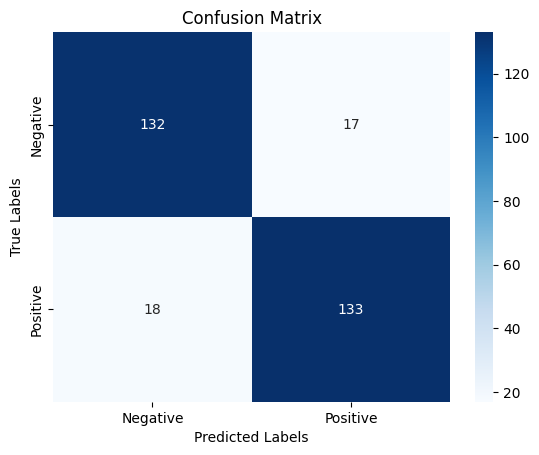

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = logits.argmax(axis=-1)

conf_matrix = confusion_matrix(true_labels, predictions)

print("Confusion Matrix:")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()